# Sentiment Analysis

Preprocess the data:

In [1]:
import keras
import re
import string
from unicodedata import normalize
import numpy
from keras.utils import to_categorical
import numpy as np

# load data
with open("negative.review", "r",encoding='iso8859-1') as f:
    negativeData1 = f.readlines()
with open("positive.review", "r",encoding='iso8859-1') as f:
    positiveData2 = f.readlines()
    
# extract review
def to_review(doc):
    output = ''
    flag = 0
    rev = list()
    for n in range(len(doc)):
        if (flag == 1):
            if (doc[n]=='</review_text>\n'):
                flag = 0
                continue
            else:
                rev.append(doc[n])
        
        if (doc[n]!='<review_text>\n'):
            continue
        else:
            flag = 1
            continue
    return rev

negativeData1 = to_review(negativeData1)
positiveData2 = to_review(positiveData2)

# transform document into paragraphs
def to_paras(doc):
    output = ''
    for n in range(len(doc)):
        output = output + doc[n]
    lines = output.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    
    output2 = ''
    for n in range(len(pairs)):
        output2 += pairs[n][0]
        if (pairs[n][0]==''):
            output2 += '\n'

    lines = output2.strip().split('\n')
    return lines

negativeData1= to_paras(negativeData1)
positiveData2= to_paras(positiveData2)
    
# cal the number of paragraphs
negativeData1_len = len(negativeData1)
positiveData2_len = len(positiveData2)
print('The paragraphs of each dataset:')
print('negative Data:%d'%(negativeData1_len))
print('positive Data:%d'%(positiveData2_len))

#joint train data
train_data = negativeData1 + positiveData2
train_data_len = len(train_data)
print('The paragraphs of train data:%d'%(train_data_len))

# cal the max length of one paragraphs
max_seq_length = max(len(line) for line in train_data)
print('\nThe max length of one paragraphs: %d'%max_seq_length)


The paragraphs of each dataset:
negative Data:1271
positive Data:974
The paragraphs of train data:2245

The max length of one paragraphs: 13861


In [2]:
#  Preprocess the data: build the vocabulary, tokenize, etc.
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = train_data_len # most N appeared words
train_data_len = 200 # each paras take N words

lines = train_data
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') ## 使用的最大词语数为max_words
tokenizer.fit_on_texts(lines) #1.token 2.build dict
word_index = tokenizer.word_index
seqs = tokenizer.texts_to_sequences(lines) # list of list
seqs_pad = pad_sequences(seqs, maxlen=train_data_len, padding='post')

In [3]:
# joint label data

negativeTarget1=[0]*negativeData1_len
positiveTarget2=[1]*positiveData2_len
label_data = negativeTarget1  + positiveTarget2
label_data = np.array(label_data) 
print('The size of label data: %s'%(str(label_data.shape)))
print('The size of training data: %s'%(str(seqs_pad.shape)))

The size of label data: (2245,)
The size of training data: (2245, 200)


In [4]:
# onehot data
def onehot_target(sequences, vocab_size):
    n = len(sequences)
    data = numpy.zeros((n, vocab_size))
    for i in range(n):
        data[i,:] = to_categorical(sequences[i], num_classes=vocab_size)
    return data

label_data_onehot = onehot_target(label_data,2)# encoder_input_seq, max_encoder_seq_length, num_encoder_tokens
train_data_onehot = seqs_pad

print('The size of train_data_onehot: %s'%(str(train_data_onehot.shape)))
print('The size of label_data_onehot: %s'%(str(label_data_onehot.shape)))

The size of train_data_onehot: (2245, 200)
The size of label_data_onehot: (2245, 2)


In [5]:
### partition the dataset to training, validation, and test.###
from sklearn.model_selection import train_test_split

# Randomly partition the dataset
train_X,test_X,train_y,test_y = train_test_split(train_data_onehot,label_data_onehot,test_size=0.2,random_state=5)
train_X,valid_X,train_y,valid_y = train_test_split(train_X,train_y,test_size=0.25,random_state=5)

In [6]:
print('The size of train_X: %s'%(str(train_X.shape)))
print('The size of train_y: %s'%(str(train_y.shape)))
print('The size of valid_X: %s'%(str(valid_X.shape)))
print('The size of valid_y: %s'%(str(valid_y.shape)))
print('The size of test_X: %s'%(str(test_X.shape)))
print('The size of test_y: %s'%(str(test_y.shape)))

The size of train_X: (1347, 200)
The size of train_y: (1347, 2)
The size of valid_X: (449, 200)
The size of valid_y: (449, 2)
The size of test_X: (449, 200)
The size of test_y: (449, 2)


# Build your models, Backpropagation, Train you model, Compare models:

LSTM model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          287488    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 435,842
Trainable params: 435,842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
43/43 [==============================] - 9s 155ms/step - loss: 0.6921 - accuracy: 0.5216 - val_loss: 0.68

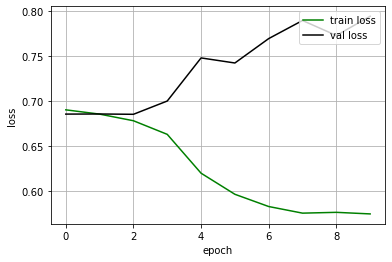

In [7]:
# try use the last hidden state as the context vector for prediction.

from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.layers import *
from keras.models import Model,Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
import numpy as np

# the number of epochs
epoch_num = 10

## define LSTM
max_len = train_data_len
model = Sequential()
model.add(Embedding(max_words+1,128,input_length=max_len))
model.add(LSTM(128, return_sequences=False))# try use the last hidden state as the context vector for prediction.
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
# The output layer prediction function can be a sigmoid function and the loss function for this task can be binary cross-entropy loss
model.add(Dense(2,activation="sigmoid"))
model.summary()
model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=["accuracy"]) # use a learning rate of 1e-3 and an Adam optimizer

#Plot the curves of training and validation loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.val_loss['batch'].append(logs.get('val_loss'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.show()
history = LossHistory()

# fit
model_fit = model.fit(train_X,train_y,batch_size=32,epochs=epoch_num,
                      validation_data=(valid_X,valid_y),
                      callbacks=[history]
                     )

# predict
y_pred  = model.predict(test_X)
y_true = test_y

# F1
print(classification_report(np.argmax(y_true,axis=1), np.argmax(y_pred,axis=1)))

# Plot the curves of training and validation loss
history.loss_plot('epoch')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          287488    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 345,474
Trainable params: 345,474
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
43/43 [==============================] - 6s 79ms/step - loss: 0.6902 - accuracy: 0.5401 - val_loss: 0.6

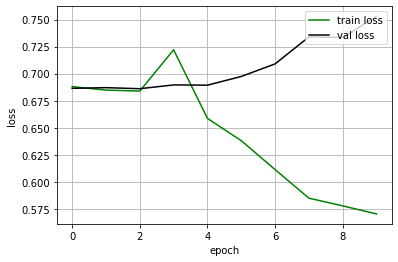

In [8]:
# Tune the parameters: hidden state size for LSTM 128 to 64

## define LSTM
max_len = train_data_len
model = Sequential()
model.add(Embedding(max_words+1,128,input_length=max_len))
model.add(LSTM(64, return_sequences=False))# Tune the parameters: hidden state size for LSTM 128 to 64
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
# The output layer prediction function can be a sigmoid function and the loss function for this task can be binary cross-entropy loss
model.add(Dense(2,activation="sigmoid"))
model.summary()
model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=["accuracy"]) # use a learning rate of 1e-3 and an Adam optimizer

# fit
model_fit = model.fit(train_X,train_y,batch_size=32,epochs=epoch_num,
                      validation_data=(valid_X,valid_y),
                      callbacks=[history]
                     )

# predict
y_pred  = model.predict(test_X)
y_true = test_y

# F1
print(classification_report(np.argmax(y_true,axis=1), np.argmax(y_pred,axis=1)))

# Plot the curves of training and validation loss
history.loss_plot('epoch')

select hyperparameters for LSTM:

When hidden state size for LSTM is 64, the model have smaller valid loss and higher accuray.
So, 64 is the best hyperparameter for hidden state size.

CNN model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          287488    
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 256)          164096    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 67, 256)           0         
_________________________________________________________________
flatten (Flatten)            (None, 17152)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17152)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34306     
Total params: 485,890
Trainable params: 485,890
Non-trainable params: 0
________________________________________________

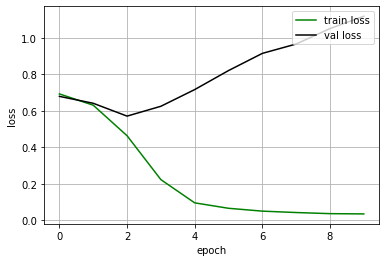

In [9]:
## define CNN

max_len = train_data_len
model = Sequential()
model.add(Embedding(max_words+ 1, 128, input_length=max_len)) 
model.add(Conv1D(256, 5, padding='same'))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.1))
# The output layer prediction function can be a sigmoid function and the loss function for this task can be binary cross-entropy loss
model.add(Dense(2, activation='sigmoid'))
model.summary()
model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=["accuracy"]) # use a learning rate of 1e-3 and an Adam optimizer

# fit
model_fit = model.fit(train_X,train_y,batch_size=32,epochs=epoch_num,
                      validation_data=(valid_X,valid_y),
                      callbacks=[history]
                     )

# predict
y_pred  = model.predict(test_X)
y_true = test_y

# F1
print(classification_report(np.argmax(y_true,axis=1), np.argmax(y_pred,axis=1)))

# Plot the curves of training and validation loss
history.loss_plot('epoch')


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          287488    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 67, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8576)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8576)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 17154     
Total params: 386,690
Trainable params: 386,690
Non-trainable params: 0
________________________________________________

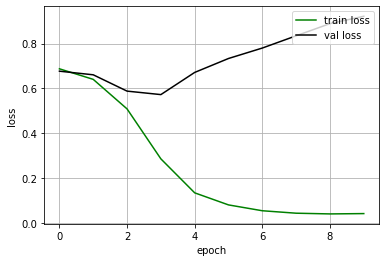

In [10]:
# Tune the parameters: the filter size for CNN, 256 to 128

## define CNN

max_len = train_data_len
model = Sequential()
model.add(Embedding(max_words+ 1, 128, input_length=max_len))
model.add(Conv1D(128, 5, padding='same')) # Tune the parameters: the filter size for CNN, 256 to 128
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.1))
# The output layer prediction function can be a sigmoid function and the loss function for this task can be binary cross-entropy loss
model.add(Dense(2, activation='sigmoid'))
model.summary()
model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=["accuracy"]) # use a learning rate of 1e-3 and an Adam optimizer

# fit
model_fit = model.fit(train_X,train_y,batch_size=32,epochs=epoch_num,
                      validation_data=(valid_X,valid_y),
                      callbacks=[history]
                     )

# predict
y_pred  = model.predict(test_X)
y_true = test_y

# F1
print(classification_report(np.argmax(y_true,axis=1), np.argmax(y_pred,axis=1)))

# Plot the curves of training and validation loss
history.loss_plot('epoch')

select hyperparameters for CNN:

These two hyperparameters have almost the same performance. We can see that the model is overfitting.
When the filter size for CNN is 128, the model have smaller valid loss and higher accuray.
So, 128 is the best the filter size for CNN.